In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
links_df = pd.read_csv("ml-latest-small/links.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
results_df = pd.read_csv("results.csv")

In [3]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
results_df.head()

,Unnamed: 0,id,title,overview,poster_path,video_key
0,0,862.0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",/uXDfjJbdP4ijW5hWSBrPrlKpxab_Toy_Story.jpg,v-PjgYDrg70
1,1,8844.0,Jumanji,When siblings Judy and Peter discover an encha...,/vgpXmVaVyUL7GGiDeiK1mKEKzcX_Jumanji.jpg,eTjDsENDZ6s
2,2,15602.0,Grumpier Old Men,A family wedding reignites the ancient feud be...,/1FSXpj5e8l4KH6nVFO5SPUeraOt_Grumpier_Old_Men.jpg,rEnOoWs3FuA
3,3,31357.0,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",/4wjGMwPsdlvi025ZqR4rXnFDvBz_Waiting_to_Exhale...,j9xml1CxgXI
4,4,11862.0,Father of the Bride Part II,Just when George Banks has recovered from his ...,/rj4LBtwQ0uGrpBnCELr716Qo3mw_Father_of_the_Bri...,_Pv5qMpwrdU


## Users

In [7]:
len(ratings_df['userId'].unique())

610

## Ratings per user

<AxesSubplot:ylabel='Frequency'>

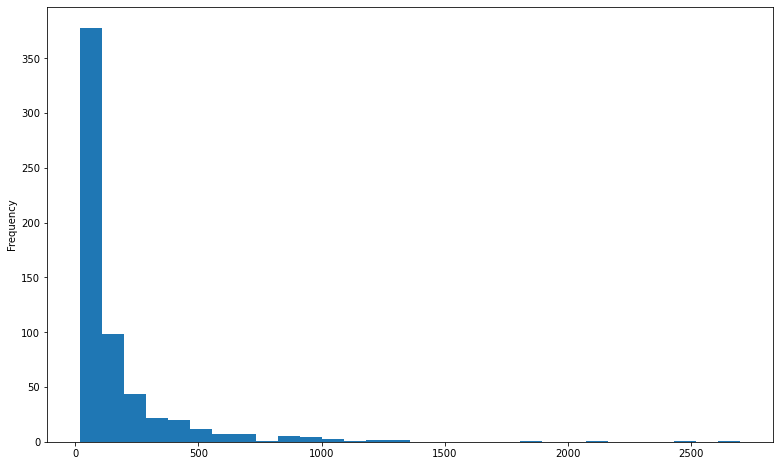

In [8]:
ratings_df.groupby('userId')['rating'].agg(len).plot.hist(bins=30, figsize=(13,8))

In [9]:
ratings_df.groupby('userId')['rating'].agg(len).describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64

## Genres

In [10]:
genres_df = pd.DataFrame({"genre":list(set(np.concatenate(movies_df['genres'].apply(lambda g: g.split("|")).values)))})
genres_df = genres_df.loc[genres_df['genre'] != '(no genres listed)'].reset_index(drop=True)

In [11]:
genres_df

,genre
0,Romance
1,Thriller
2,Film-Noir
3,Drama
4,Crime
5,Action
6,Western
7,Musical
8,Adventure
9,Children


In [12]:
movies_no_genre = movies_df.loc[movies_df['genres'].str.contains('(no genres listed)')]

C:\Users\geomimo\anaconda3\envs\webscrap\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [13]:
movies_df = movies_df.loc[~movies_df['movieId'].isin(movies_no_genre['movieId'])]

## MovieGenres

In [14]:
def assign_moviegenres(movie):
    genres = movie['genres'].split('|')
    genres_id = genres_df.loc[genres_df['genre'].isin(genres)]
    return pd.Series({'movieId': movie['movieId'], 'genresId': ','.join(map(str, np.array(genres_id.index.tolist()) + 1))})

In [15]:
moviesgenre_df = movies_df.apply(lambda movie: assign_moviegenres(movie), axis=1)

In [16]:
moviesgenre_df.head()

,movieId,genresId
0,1,"9,10,11,12,13"
1,2,"9,10,12"
2,3,"1,11"
3,4,"1,4,11"
4,5,11


## Movies

In [27]:
results_df['poster_path'] = results_df['poster_path'].str.split('_').str[0] + ".jpg"

In [28]:
movies_df = movies_df.merge(results_df, left_on="movieId", right_on="id").drop(["id", "title_x"], axis=1).rename({"title_y": "title"}, axis=1)
movies_df['video_key'] = "https://www.youtube.com/embed/" + movies_df['video_key']
movies_df.drop("genres", axis=1, inplace=True)
movies_df = movies_df.merge(moviesgenre_df, on='movieId')


In [29]:
movies_df.drop_duplicates(subset='movieId', inplace=True)
movies_df.dropna(inplace=True)

In [30]:
movies_df['overview'] = movies_df['overview'].apply(lambda o: o.replace('\n', ' '))

In [31]:
movies_df.head()

,movieId,Unnamed: 0,title,overview,poster_path,video_key,genresId
0,5,17,Four Rooms,It's Ted the Bellhop's first night on the job....,/75aHn1NOYXh4M7L5shoeQ6NGykP.jpg,https://www.youtube.com/embed/S_Pd2pGkq54,11
1,6,390,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",/rYFAvSPlQUCebayLcxyK79yvtvV.jpg,https://www.youtube.com/embed/G5p7wq2PcJM,"2,5,6"
2,11,212,Star Wars,Princess Leia is captured and held hostage by ...,/6FfCtAuVAW8XJjZ7eWeLibRLWTw.jpg,https://www.youtube.com/embed/XHk5kCIiGoM,"1,4,11"
3,12,4013,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",/eHuGQ10FUzK1mdOY69wF5pGgEf5.jpg,https://www.youtube.com/embed/TOQsDiEc7nk,"11,16"
4,13,291,Forrest Gump,A man with a low IQ has accomplished great thi...,/h5J4W4veyxMXDMjeNxZI46TsHOb.jpg,https://www.youtube.com/embed/bLvqoHBptjg,"9,10,13"


## Posts

In [32]:
movies_to_users_df = ratings_df.loc[ratings_df['movieId'].isin(movies_df['movieId'].values)].groupby('movieId').sample(n=1).reset_index(drop=True)

In [33]:
movies_to_users_df.head()

,userId,movieId,rating,timestamp
0,509,5,1.5,1435992893
1,592,6,3.0,837350390
2,438,11,4.0,1105668426
3,350,12,3.0,864941118
4,476,13,3.0,835022487


## Ratings

In [34]:
ratings_df = ratings_df.loc[ratings_df['movieId'].isin(movies_df['movieId'].values)].drop('timestamp', axis=1)

In [35]:
ratings_df.head()

,userId,movieId,rating
2,1,6,4.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
9,1,157,5.0


## Users

In [36]:
users_df = pd.DataFrame({"userId": ratings_df['userId'].unique()})

In [37]:
users_df['is_content_manager'] = users_df['userId'].isin(movies_to_users_df['userId'].values)

In [38]:
users_df.head()

,userId,is_content_manager
0,1,True
1,2,False
2,3,True
3,4,True
4,5,True


In [41]:
genres_df.to_csv('DataInit/genres.csv')
movies_df.to_csv('DataInit/movies.csv')
movies_to_users_df.to_csv('DataInit/posts.csv')
ratings_df.to_csv('DataInit/ratings.csv')
ratings_df.to_csv('train.csv', index=False)

users_df.to_csv('DataInit/users.csv')

In [40]:
len(movies_df['movieId'].unique())

1394